# Uncertainty quantification
in this notebook the uncertainty of already trained models is researched. as a first approch an ensemble method is used.

In [48]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("uncertainty quantification")

client = MlflowClient()
experiments = client.search_experiments(filter_string="name = 'uncertainty quantification'")
experiment_id = experiments[0].experiment_id
runs = client.search_runs(experiment_ids=[experiment_id])
parent_runs = [run for run in runs if 'mlflow.parentRunId' not in run.data.tags]


## 2. Data

In [6]:
import pandas as pd
val_data = pd.read_csv("./data/raw/validationdata.csv")
i = val_data[["id","iq"]].values

## 3. UQ

In [49]:
parent_runs = [run for run in parent_runs if run.data.tags.get('mlflow.runName') == "run with boundary of 300A random dropout"]
parent_run = parent_runs[0]
child_runs = []
for run in runs:
    if 'mlflow.parentRunId'  in run.data.tags:
        if run.data.tags['mlflow.parentRunId'] == parent_run.info.run_id:
            child_runs.append(run)

### 3.1 deep ensemble

In [147]:
import joblib
import torch
from steps.compute import compute_differential_inductances_fast as cdif
from steps.compute import physical_parameters_to_state_space as pp2ss
l_pred = []
psi_pred = []
ss_pred =[]

for child_run in child_runs:
    run_id = child_run.info.run_id

    model_uri = f"runs:/{run_id}/model"
    model = mlflow.pytorch.load_model(model_uri)

    artifact_path = "scaler/scaler.pkl"
    local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)
    scaler = joblib.load(local_path)
    
    i_np_scaled = scaler.transform(i)
    i_scaled = torch.tensor(i_np_scaled,dtype=torch.float32)
    i_scaled.requires_grad_(True)
    psi,r = model(i_scaled)
    psi_pred.append(psi)
    
    L = cdif(psi,i_scaled,scaler)
    l_pred.append(L)
    
    ss = pp2ss(psi,L,r,418.879020478639)
    ss_pred.append(torch.column_stack(ss))

c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\valida

### 3.2 Pseudo MC-Dropout
Use a model wich was trained without dropouit

In [39]:
import torch.nn as nn
import joblib
import torch
from steps.compute import compute_differential_inductances_fast as cdif
from steps.compute import physical_parameters_to_state_space as pp2ss


class ModelWithDropout(nn.Module):
    def __init__(self,original_model,dropout_prob):
        super().__init__()
        layers =[]
        
        for layer in original_model.model:
            layers.append(layer)
            if isinstance(layer,nn.Tanh):
                layers.append(nn.Dropout(p=dropout_prob))
                
        self.model = nn.Sequential(*layers)
        self.r = original_model.r
        
    def forward(self,x):
        return self.model(x), self.r
        

run_id = child_runs[0].info.run_id

model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
df = pd.DataFrame()
#groundtruth values
psi_true = torch.tensor(val_data[["psid","psiq"]].values)
l_true = torch.tensor(val_data[["ldd","ldq","lqd","lqq"]].values)
ss_true = torch.column_stack(pp2ss(psi_true,l_true,torch.tensor([0.02301]),torch.tensor([418.879020478639])))

#no dropout inference
psi,r = model(i_scaled)
L = cdif(psi,i_scaled,scaler)
ss = pp2ss(psi,L,r,418.879020478639)
psi_error_no_dropout = torch.mean(torch.abs(psi_true-psi.detach()),dim=1)
l_error_no_dropout = torch.mean(torch.abs(l_true-L.detach()),dim=1)
ss_error_no_dropout = torch.mean(torch.abs(ss_true-torch.column_stack(ss).detach()),dim=1)

for dropout_prob in [0.1,0.05,0.01]:
    sub_df = pd.DataFrame()
    l_pred = []
    psi_pred = []
    ss_pred =[]
    model_with_dropout = ModelWithDropout(model,dropout_prob)

    artifact_path = "scaler/scaler.pkl"
    local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)
    scaler = joblib.load(local_path)

    i_np_scaled = scaler.transform(i)
    i_scaled = torch.tensor(i_np_scaled,dtype=torch.float32)
    i_scaled.requires_grad_(True)

    for _ in range(50):
        psi,r = model_with_dropout(i_scaled)
        psi_pred.append(psi)
        
        L = cdif(psi,i_scaled,scaler)
        l_pred.append(L)
        
        ss = pp2ss(psi,L,r,418.879020478639)
        ss_pred.append(torch.column_stack(ss))
        
    psi_pred = torch.stack(psi_pred).detach()
    l_pred = torch.stack(l_pred).detach()
    ss_pred = torch.stack(ss_pred).detach()

    psi_var = torch.mean(torch.var(psi_pred,dim=0),dim=1)
    l_var = torch.mean(torch.var(l_pred,dim=0),dim=1)
    ss_var = torch.mean(torch.var(ss_pred,dim=0),dim=1)
    
    psi_mean = torch.mean(psi_pred,dim=0)
    psi_error = torch.mean(torch.abs(psi_true-psi_mean),dim=1)
    l_mean = torch.mean(l_pred,dim=0)
    l_error = torch.mean(torch.abs(l_true-l_mean),dim=1)
    ss_mean = torch.mean(ss_pred,dim=0)
    ss_error = torch.mean(torch.abs(ss_true-ss_mean),dim=1)

    sub_df["ss_var"]= ss_var
    sub_df["ss_error"] = ss_error
    sub_df["dropout_prob"] = dropout_prob
    sub_df["ss_error_no_dropout"] = ss_error_no_dropout
    df = pd.concat([df,sub_df])


c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 3.3 real MC-dropout


In [59]:
import torch.nn as nn
import joblib
import torch
from steps.compute import compute_differential_inductances_fast as cdif
from steps.compute import physical_parameters_to_state_space as pp2ss

run_id = child_runs[0].info.run_id

model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.train()
l_pred = []
psi_pred = []
ss_pred =[]


artifact_path = "scaler/scaler.pkl"
local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)
scaler = joblib.load(local_path)

i_np_scaled = scaler.transform(i)
i_scaled = torch.tensor(i_np_scaled,dtype=torch.float32)
i_scaled.requires_grad_(True)

for _ in range(100):
    psi,r = model(i_scaled)
    psi_pred.append(psi)
    
    L = cdif(psi,i_scaled,scaler)
    l_pred.append(L)
    
    ss = pp2ss(psi,L,r,418.879020478639)
    ss_pred.append(torch.column_stack(ss))
    
psi_pred = torch.stack(psi_pred).detach()
l_pred = torch.stack(l_pred).detach()
ss_pred = torch.stack(ss_pred).detach()

psi_var = torch.mean(torch.var(psi_pred,dim=0),dim=1)
l_var = torch.mean(torch.var(l_pred,dim=0),dim=1)
psi_mean = torch.mean(psi_pred,dim=0)
psi_true = torch.tensor(val_data[["psid","psiq"]].values)
psi_error = torch.mean(torch.abs(psi_true-psi_mean),dim=1)
l_mean = torch.mean(l_pred,dim=0)
l_true = torch.tensor(val_data[["ldd","ldq","lqd","lqq"]].values)
l_error = torch.mean(torch.abs(l_true-l_mean),dim=1)
ss_true = torch.column_stack(pp2ss(psi_true,l_true,torch.tensor([0.02301]),torch.tensor([418.879020478639])))
ss_mean = torch.mean(ss_pred,dim=0)
ss_error = torch.mean(torch.abs(ss_true-ss_mean),dim=1)
ss_var = torch.mean(torch.var(ss_pred,dim=0),dim=1)

MC_df = pd.DataFrame({"ss_error":ss_error,"ss_var":ss_var,"dropout_prob":"training"})


c:\Users\JANLUKS\Desktop\dokumente\python\ML\FluxNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 4. Evaluation

In [10]:
d_border = []
q_border = []
for deg in range(181):
    d_border.append(300*np.cos(np.deg2rad(90+deg)))
    q_border.append(300*np.sin(np.deg2rad(90+deg)))

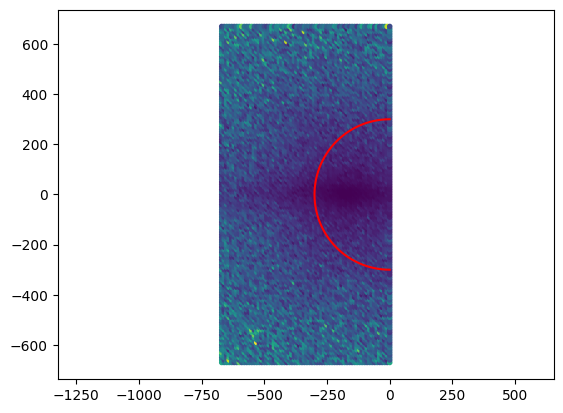

In [13]:
import matplotlib.pyplot as plt
plt.scatter(i[:,0],i[:,1],c = psi_var,marker =".")
plt.plot(d_border,q_border,c="red")
plt.axis("equal")
plt.show()

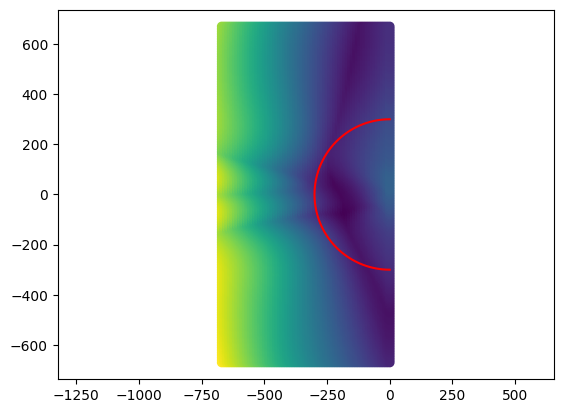

In [9]:
import matplotlib.pyplot as plt
plt.scatter(i[:,0],i[:,1],c = psi_error)
plt.plot(d_border,q_border,c="red")
plt.axis("equal")
plt.show()

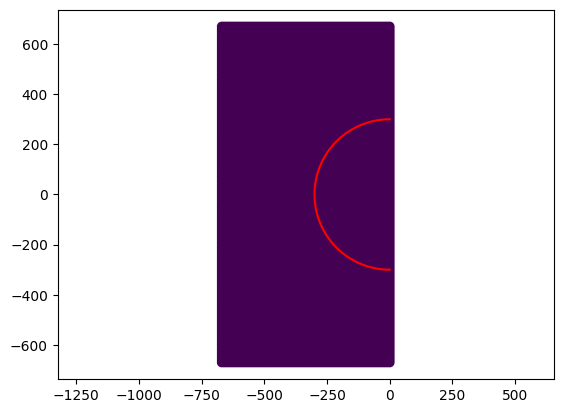

In [10]:
import matplotlib.pyplot as plt

plt.scatter(i[:,0],i[:,1],c = l_var)
plt.plot(d_border,q_border,c="red")
plt.axis("equal")
plt.show()

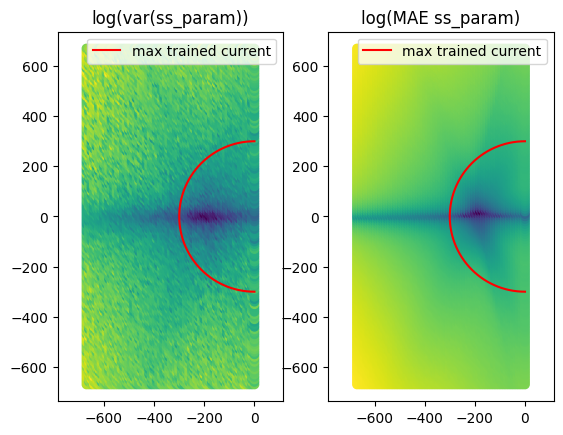

In [14]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.scatter(i[:,0],i[:,1],c = torch.log(ss_var))
plt.title("log(var(ss_param))")
plt.plot(d_border,q_border,c="red",label="max trained current")
plt.legend()
plt.axis("equal")

plt.subplot(1,2,2)
plt.scatter(i[:,0],i[:,1],c = torch.log(ss_error))
plt.plot(d_border,q_border,c="red",label="max trained current")
plt.title("log(MAE ss_param)")
plt.axis("equal")
plt.legend()
plt.show()

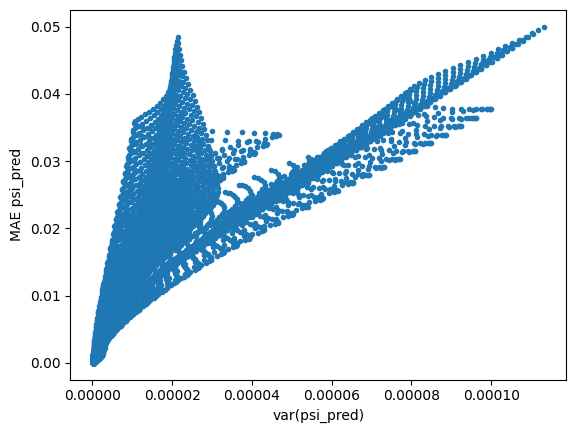

In [30]:
plt.scatter(psi_var,psi_error,marker=".")
plt.xlabel("var(psi_pred)")
plt.ylabel("MAE psi_pred")

plt.show()

Text(0.05, 0.95, 'Korrelation: 0.81')

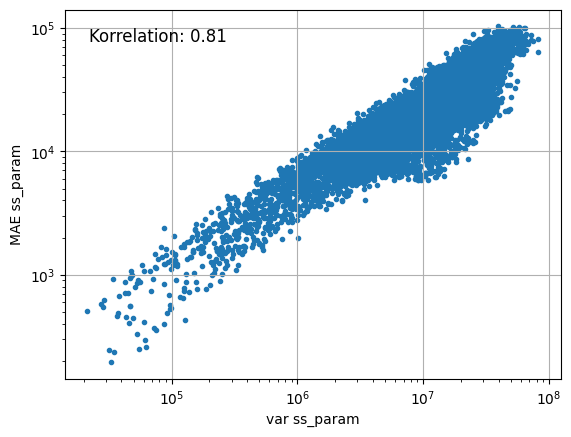

In [54]:
x = ss_var
y = ss_error

plt.scatter(x,y,marker=".")
plt.xscale("log")
plt.yscale("log")
plt.grid("on")
plt.xlabel("var ss_param")
plt.ylabel("MAE ss_param")
corr = np.corrcoef(x,y)[0,1]
plt.text(0.05,0.95,f"Korrelation: {corr:.2f}",
         transform=plt.gca().transAxes, 
         fontsize=12, 
         verticalalignment='top')

In [149]:
ensemble_df = pd.DataFrame({"ss_error":ss_error,"ss_var":ss_var,"dropout_prob":"ensemble"})
compare_df = pd.concat([df,ensemble_df])
compare_df = compare_df.reset_index(drop=True)

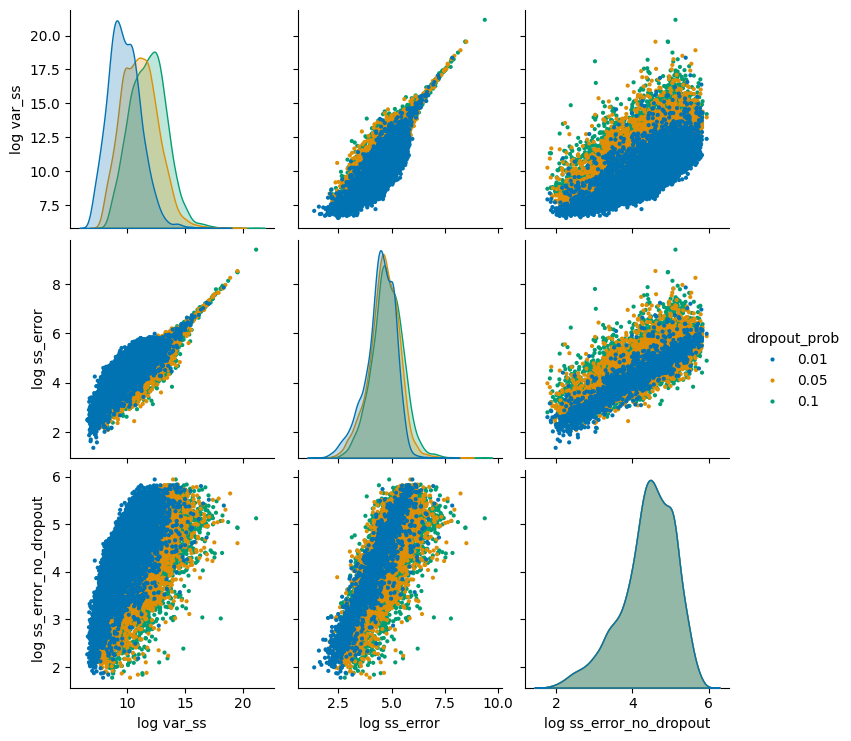

In [40]:

import seaborn as sns
df = df.reset_index(drop=True)
df["log var_ss"] = np.log10(df["ss_var"])
df["log sigma_ss"] = np.log10(np.sqrt(df["ss_var"]))
df["log ss_error"] = np.log10(df["ss_error"])
df["log ss_error_no_dropout"] = np.log10(df["ss_error_no_dropout"])
sns.pairplot(data =df,vars = ["log var_ss","log ss_error","log ss_error_no_dropout"],palette = "colorblind",hue="dropout_prob",markers=".",plot_kws={'edgecolor': 'none'})
#for ax in pp.axes.flatten():
#    ax.set_xscale("log")
#    ax.set_yscale("log")

<Axes: xlabel='dropout_prob', ylabel='log ss_error'>

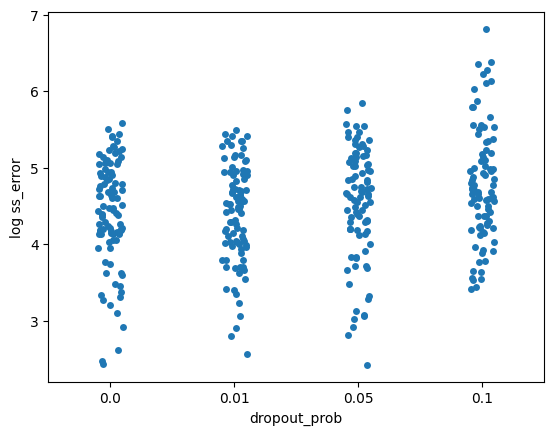

In [17]:
sns.stripplot(data=df.sample(frac=0.01),x="dropout_prob",y="log ss_error")

<Axes: xlabel='dropout_prob', ylabel='log ss_error'>

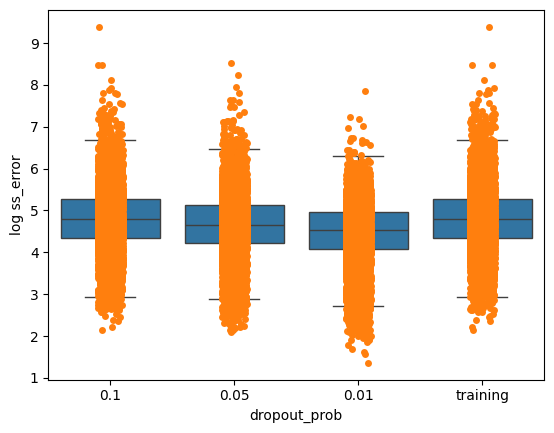

In [61]:
sns.boxplot(data=pd.concat([df,MC_df]),x="dropout_prob",y="log ss_error",showfliers=False)
sns.stripplot(data=pd.concat([df,MC_df]),x="dropout_prob",y="log ss_error")

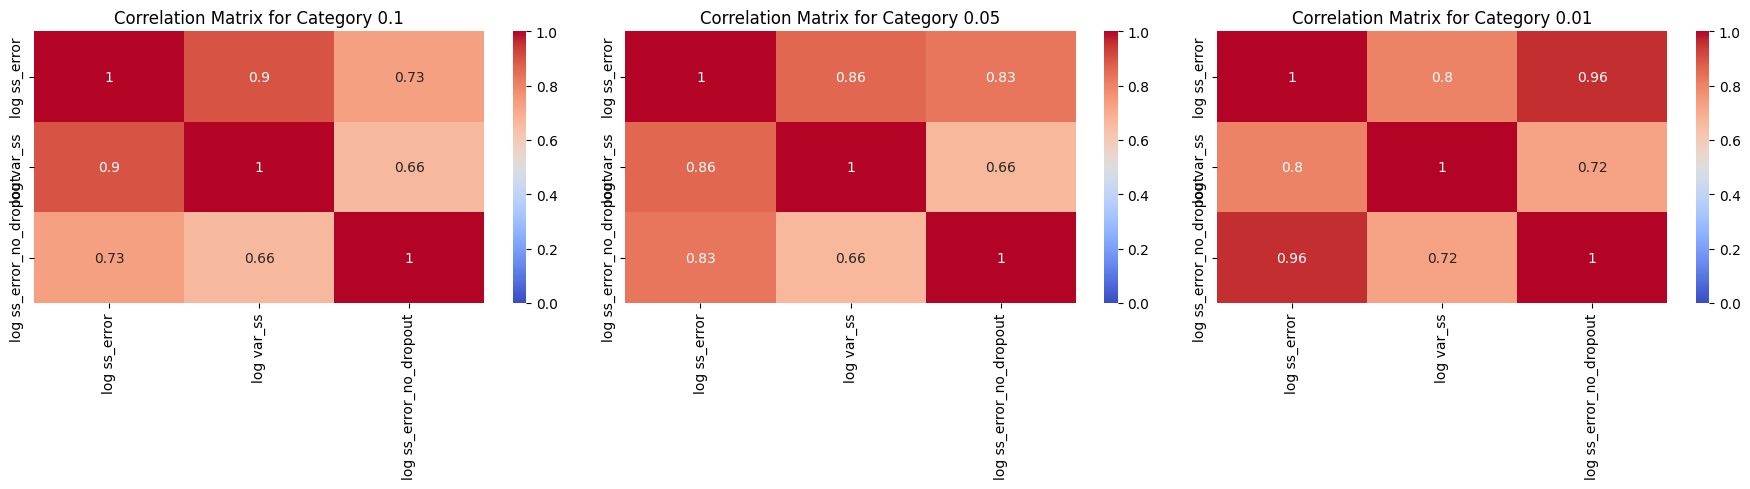

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrices(df, category_col, columns_to_investigate=None):
    """
    Plots correlation matrices for each unique category in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    category_col (str): The name of the column containing categories.
    columns_to_investigate (list, optional): List of columns to include in the correlation matrix. If None, all columns except the category column are used.
    """
    if columns_to_investigate is None:
        columns_to_investigate = [col for col in df.columns if col != category_col]

    categories = df[category_col].unique()
    num_categories = len(categories)
    fig, axes = plt.subplots(1, num_categories, figsize=(6 * num_categories, 5))

    if num_categories == 1:
        axes = [axes]

    for i, category in enumerate(categories):
        df_category = df[df[category_col] == category]
        corr_matrix = df_category[columns_to_investigate].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[i],vmin=0,vmax=1)
        axes[i].set_title(f'Correlation Matrix for Category {category}')

    plt.tight_layout()
    plt.show()


# Plot correlation matrices for inferred categories
plot_correlation_matrices(df, 'dropout_prob',["log ss_error","log var_ss","log ss_error_no_dropout"])

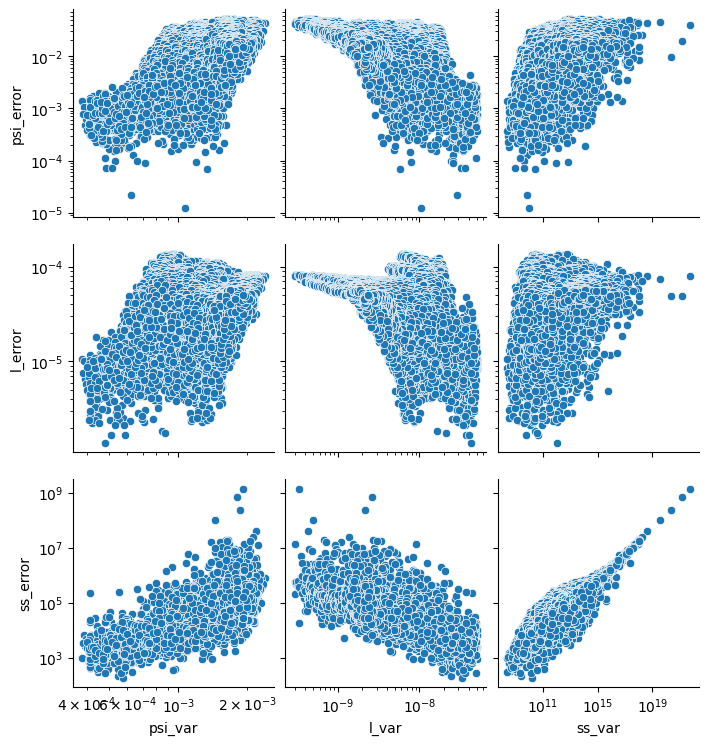

In [29]:
all_data = pd.DataFrame({"psi_var":psi_var,"psi_error":psi_error,
                         "l_var":l_var,"l_error":l_error,
                         "ss_var":ss_var,"ss_error":ss_error})
import seaborn as sns

pp = sns.pairplot(all_data,x_vars=["psi_var","l_var","ss_var"],y_vars=["psi_error","l_error","ss_error"])

for ax in pp.axes.flatten():
    if ax.get_xlabel() in ["ss_var","psi_var","l_var"]:
        ax.set_xscale("log")
    if ax.get_ylabel() in ["ss_error","psi_error","l_error"]:
        ax.set_yscale("log")

plt.show()

<Axes: ylabel='log ss_error'>

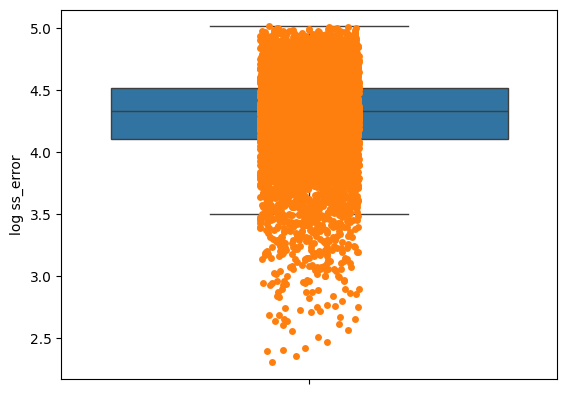

In [58]:
import numpy as np
MC_df["log ss_error"] = np.log10(MC_df["ss_error"])
sns.boxplot(MC_df,y ="log ss_error",showfliers=False )
sns.stripplot(MC_df,y="log ss_error")